<a href="https://colab.research.google.com/github/IshitaGopal/TelegramProject_23/blob/main/translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install transformers
!pip install SentencePiece
!pip install sacremoses
!pip install accelerate>=0.12.0
!pip install bitsandbytes>=0.31.5


In [ ]:
from transformers import MarianMTModel, MarianTokenizer, AutoTokenizer
import pandas as pd
import torch
from tqdm import tqdm
from tqdm import tqdm_notebook
import re
import math

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
device


device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Get data (sample 100 messages) from google drive
df = pd.read_csv("/content/drive/MyDrive/Telegram/analysis_data/telegram_data_sample_2020-08-09_2021-04-01.csv")

# Print out the first message 
df.message[0]

'Не смешите, интеграции не будет, беларусы уже не те бесхребетные молчаливый амёбы, если подует ветер народ даст отпор'

In [ ]:
# sentence tokenize 
# Tokenize sentences for each paragraph
df['sentences'] = df['message'].apply(lambda x: nltk.sent_tokenize(x))


NameError: ignored

In [ ]:
f_ = "sentTokenized_sample_Aug_Mar_2023-02-04.csv"
df = pd.read_csv(f_)
print(df.shape)


(82864, 7)


In [ ]:
df.head(2)

,unique_msg_id,message,sentences,sent_idx,clean_sent,sent_Emojis,msg_len
0,majakrainablr_1145117,Шлюха,Шлюха,0,Шлюха,NaN,5
1,Svetlogorskchat_83952,плин. я не ваша таксистка но гугл картами умею...,плин.,0,плин.,NaN,5


In [ ]:
# convert the text column into a list
text_list = list(df["clean_sent"])

In [ ]:
# filt = df.clean_sent_noEmoji.str.contains("Друзья, мы подготовили для вас список рабочих VPN")
# df[filt]
# df.loc[5914:5920]
# df[df.index == 47283]
# df[df.unique_msg_id == "grodno97pro_33622"]["clean_sent_noEmoji"]

In [ ]:
# df.clean_sent_noEmoji[45250:45260]

In [ ]:
# sample_text = text_list[45254]
# pd.Series(sample_text).str.len()

In [ ]:
# model_name = f'Helsinki-NLP/opus-mt-ru-en'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokens = tokenizer(sample_text, return_tensors = 'pt')
#tokens = tokenizer(sample_text, return_tensors = 'pt', padding = True, max_length=512, truncation=True)

# tokens

In [ ]:
#tokens = tokenizer(sample_text, return_tensors = 'pt', padding = True, max_length=512, truncation=True)
#tokens

In [ ]:
text_list[0]

'Шлюха'

In [ ]:
df.sentences[:10]

0        Шлюха
1        плин.
2        Видел
3        Дичь.
4        Было.
5        Емае.
6      ШОС !!!
7        Бабки
8        Ловлю
9    Клоун😂😂😂😂
Name: sentences, dtype: object

In [ ]:
def marian_batch_translator(texts, src, trg, batch_size = 10):
  '''
  Function takes a list of texts, a source language, target language, and batch size
  Downloads the appropriate MarianMT model & tokenizer
  tokenizes and translates input texts in batches.
  '''
  model_name = f'Helsinki-NLP/opus-mt-{src}-{trg}'
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  #tokenizer = MarianTokenizer.from_pretrained(model_name)
  model = MarianMTModel.from_pretrained(model_name)

  batches = math.ceil(len(texts) / batch_size) # determine how many batches we need

  translations = [None] * 1000 # empty list to store output translations 

  for i in tqdm(range(0,batches)): # iterate through batches (tqdm creates a progress bar)
    start = i*batch_size
    end = start+batch_size

    batch_texts = texts[start:end]
    batch_tokens = tokenizer(batch_texts, return_tensors = 'pt', padding = True, max_length=512, truncation=True)
    batch_generated_tokens = model.generate(**batch_tokens)
    batch_translated = tokenizer.batch_decode(batch_generated_tokens, skip_special_tokens = True)
    #translations.extend(batch_translated)
    translations[start: end] = batch_translated

  return(translations)

In [ ]:
# 25 min 100
# 40 min 200 batches
# 300 batches in 1 hour 
# 20000 --> in 3:25:26 hrs
# 2nd batch - 2:20:46 hrs
translations_4 = marian_batch_translator(texts=text_list[60000:], src="ru", trg="en")

  0%|          | 0/2287 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 2287/2287 [7:01:40<00:00, 11.06s/it]


In [ ]:
len(translations_4)

22864

In [ ]:
translations_4[:10]

['An animation film on events in Belarus since 9 August 2020.',
 'All those who are not prepared to tolerate the violence of the security forces and officials.',
 "I'd be quiet if I didn't ask in which neighborhood, and I'd know that.",
 "I'd like to go a little bit further towards the civil war scenario.",
 "By the way, he said I remembered that they didn't have enough people.",
 "Hey, neighbors, I thought you weren't alone in our house.",
 'fix the instructions you need to give here, spam bang.',
 "I don't mind going, but I'm not interested, at least 4,000.",
 'In a search at Telegram, dial OFF.',
 "And where laws are missing, you know, sometimes they don't."]

In [ ]:
df_4 = df.loc[60000:,]

In [ ]:
df_4.columns

Index(['unique_msg_id', 'message', 'sentences', 'sent_idx', 'clean_sent',
       'sent_Emojis', 'msg_len'],
      dtype='object')

In [ ]:
df_4["translation"] = translations_4

<ipython-input-61-9ccd1bb5ca80>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4["translation"] = translations_4


In [ ]:
df_4

,unique_msg_id,message,sentences,sent_idx,clean_sent,sent_Emojis,msg_len,translation
60000,soligorsk_gorod_43609,Анимационный фильм о событиях в Беларуси после...,Анимационный фильм о событиях в Беларуси после...,0,Анимационный фильм о событиях в Беларуси после...,NaN,67,An animation film on events in Belarus since 9...
60001,grodno97pro_209930,"​​С 26 ОКТЯБРЯ ОСТАНОВЯТ РАБОТУ ТЕ, \nкто хоче...","✔️ Всех, кто не готов мириться с беспределом с...",2,"️ Всех, кто не готов мириться с беспределом си...",✔,67,All those who are not prepared to tolerate the...
60002,minsk97pro_570409,"Ну капец) был бы тихарь ,не спрашивал в каком ...","Ну капец) был бы тихарь ,не спрашивал в каком ...",0,"Ну капец) был бы тихарь ,не спрашивал в каком ...",NaN,67,I'd be quiet if I didn't ask in which neighbor...
60003,Gomel_strana_66923,https://t.me/MikolaDziadok/4611\n\nИнтересную ...,Хочется немного развить мысль в сторону сценар...,1,Хочется немного развить мысль в сторону сценар...,NaN,67,I'd like to go a little bit further towards th...
60004,strana_chat_145401,"ребята, у меня брат служит сейчас он в минске....",он кстати еще сказал я тут вспомнил— то что у ...,16,он кстати еще сказал я тут вспомнил— то что у ...,NaN,67,"By the way, he said I remembered that they did..."
...,...,...,...,...,...,...,...,...
82859,strana_chat_219756,"‼️ Хотите поддержать протестующих, но не знает...","Вот развёрнутый список инициатив, помогающим в...",1,"Вот развёрнутый список инициатив, помогающим в...",NaN,1123,Here is a list of initiatives that have been d...
82860,soligorsk_gorod_53177,‼️ ПОЗОР РАБОЧИМ КОТОРЫЕ НЕ ПОДДЕРЖАЛИ ОБЩЕНАЦ...,‼️ ПОЗОР РАБОЧИМ КОТОРЫЕ НЕ ПОДДЕРЖАЛИ ОБЩЕНАЦ...,0,️ ПОЗОР РАБОЧИМ КОТОРЫЕ НЕ ПОДДЕРЖАЛИ ОБЩЕНАЦИ...,‼➡👊,1163,The President-elect turned to the nation. Ther...
82861,molodechnostrana_chat_115949,"а дзе была падтрымка народа для тых,хто заўсёд...","а дзе была падтрымка народа для тых,хто заўсёд...",0,"а дзе была падтрымка народа для тых,хто заўсёд...",NaN,1237,"And there was a people's father for you. Laty,..."
82862,Svetlogorskchat_50387,Вы не мой президент!\nУбийца Трус Предатель Во...,Насколько я помню культурно ты не умеешь разго...,3,Насколько я помню культурно ты не умеешь разго...,NaN,2068,"As far as I'm concerned, you don't know how to..."


In [ ]:
# 
translations = [df_1, df_2, df_3, df_4]

In [ ]:
translations_df = pd.concat(translations)

In [ ]:
translations_df.shape

(82864, 8)

In [ ]:
df.shape

(82864, 7)

In [ ]:
df.to_csv("translated_sentTokenized_sample_Aug_Mar_2023-02-04.csv", index=False)

In [ ]:
# check some translations for reference

for i in range(0, 10):
  print('-' * 100)
  print('Original Russian: ' + text_list[:20][i])
  print('Machine translation: ' + translations[i])
  #print('Reference translation: ' + ref_translations[i])
  print('-' * 100)
  print('\n')


----------------------------------------------------------------------------------------------------
Original Russian: Люди нужно собираться в 4 дня,поток большой идёт!!!!!!!!!!!!!!!!!!!!!
Machine translation: People need to get together at 4 o'clock, the flow's big!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Original Russian: !дороги перекрыть не смогут 
Плюсы поддержка со стороны водителей и проще перекрыть движение,вся дорога станет!
Machine translation: The roads can't shut down the Plus's support from the drivers, and it's easier to block the traffic, the whole road will become!
--------------------------------------------------------------

In [ ]:
df["translations"] = translations

In [ ]:
file_name = f"translated_{f_}"

In [ ]:
df.to_csv(file_name)

In [ ]:
# function for translation 
def marian_batch_translator(text_list, src, trg, batch_size = 10):
  '''
  Function takes a list of texts (sentences), a source language, target 
  language, and batch size Downloads the appropriate MarianMT model & tokenizer.
  tokenizes and translates input sentences in batches.
  '''
  model_name = f'Helsinki-NLP/opus-mt-{src}-{trg}'
  tokenizer = MarianTokenizer.from_pretrained(model_name)
  model = MarianMTModel.from_pretrained(model_name).to(device)

  batches = math.ceil(len(text_list) / batch_size) # determine how many batches we need
  print(batches)

  translations = [] # empty list to store output translations 

  for i in tqdm_notebook(range(0,batches)): # iterate through batches (tqdm creates a progress bar)
    start = i*batch_size
    end = start+batch_size

    batch_texts = text_list[start:end]
    batch_tokens = tokenizer(batch_texts, return_tensors = 'pt', padding = True).to(device)
    batch_generated_tokens = model.generate(**batch_tokens)
    batch_translated = tokenizer.batch_decode(batch_generated_tokens, skip_special_tokens = True)
    translations.extend(batch_translated)

  return translations

In [ ]:
# save translated text in a column in src_text df
src_text["translated_sent"] = translated

In [ ]:
# join the emojis to translated text 
src_text["translated_sent_withEmoji"] =  src_text["translated_sent"]+ (src_text["sent_Emojis"])

In [ ]:

src_text["translated_sent_withEmoji"]

0                                                 I agree.
1                      I often go to meetings in Minsk!👍👍👍
2        No offense said, but that's the atmosphere I'v...
3        And after that, how does the force structure f...
4                 May you die - civilians of the police!!!
                               ...                        
80272                                 Homedad's with you.✌
80273    Congratulations, but for such "smart" people, ...
80274                                 Let's go one-on-one.
80275                      Each of you is against me, huh?
80276                                          only emoji😁
Name: translated_sent_withEmoji, Length: 80277, dtype: object

In [ ]:
src_text["translated_sent_withEmoji"] = src_text["translated_sent_withEmoji"].str.replace("only emoji", "")

In [ ]:
src_text["translated_sent_withEmoji"] = src_text["translated_sent_withEmoji"].str.replace("small sent", "")

In [ ]:
src_text

,para_index,sent_index,sent_text,sent_text_noEmoji,sent_Emojis,translated_sent,translated_sent_withEmoji
0,0,0,Согласен,Согласен,,I agree.,I agree.
1,1,0,👍👍👍 Я в Минске часто на митинги попадаю!,Я в Минске часто на митинги попадаю!,👍👍👍,I often go to meetings in Minsk!,I often go to meetings in Minsk!👍👍👍
2,1,1,"Не в обиду сказано, но такой атмосферы как там...","Не в обиду сказано, но такой атмосферы как там...",,"No offense said, but that's the atmosphere I'v...","No offense said, but that's the atmosphere I'v..."
3,2,0,И как после этого относится к силовым структур...,И как после этого относится к силовым структур...,,"And after that, how does the force structure f...","And after that, how does the force structure f..."
4,2,1,Желаю вам сдохнуть - Граждане милиционеры!!!,Желаю вам сдохнуть - Граждане милиционеры!!!,,May you die - civilians of the police!!!,May you die - civilians of the police!!!
...,...,...,...,...,...,...,...
80272,50705,0,Домодедово с Вами✌️,Домодедово с Вами️,✌,Homedad's with you.,Homedad's with you.✌
80273,50706,0,"Поздравляю но для таких ""умных"" людей есть игнор","Поздравляю но для таких ""умных"" людей есть игнор",,"Congratulations, but for such ""smart"" people, ...","Congratulations, but for such ""smart"" people, ..."
80274,50707,0,А давай один на один.,А давай один на один.,,Let's go one-on-one.,Let's go one-on-one.
80275,50707,1,"Каждый из вас против меня, а?","Каждый из вас против меня, а?",,"Each of you is against me, huh?","Each of you is against me, huh?"


In [ ]:
# remove empty sentences 
translated_df = src_text[src_text["translated_sent_withEmoji"].str.len()!=0]

In [ ]:
translated_df.shape

(77411, 7)

In [ ]:
# group sentences into paragraphs again 
# translated_df = src_text.groupby(["msg_index"]).agg({'translated_sent_withEmoji': ' '.join}).reset_index()

In [ ]:
ru

,msg_index,para_index,para_msg,msg_id,msg_date,full_msg
0,0,0,Согласен,59694,2020-08-22,Согласен
1,1,1,👍👍👍 Я в Минске часто на митинги попадаю! Не в ...,59693,2020-08-22,👍👍👍 Я в Минске часто на митинги попадаю! Не в ...
2,2,2,И как после этого относится к силовым структур...,59692,2020-08-22,И как после этого относится к силовым структур...
3,3,3,"Был в Минске в воскресенье. Что поразило, выше...",59691,2020-08-22,"Был в Минске в воскресенье. Что поразило, выше..."
4,4,4,"Ребчта я не понимаю о ваши споры иобсуждения ,...",59687,2020-08-22,"Ребчта я не понимаю о ваши споры иобсуждения ,..."
...,...,...,...,...,...,...
50703,42923,50703,"Белорусь, такой страны нет",17109,2020-08-11,"Белорусь, такой страны нет"
50704,42924,50704,только тапоры и брать !Или мы их или они нас!Б...,17108,2020-08-11,только тапоры и брать !Или мы их или они н...
50705,42925,50705,Домодедово с Вами✌️,17103,2020-08-11,Домодедово с Вами✌️
50706,42926,50706,"Поздравляю но для таких ""умных"" людей есть игнор",17090,2020-08-11,"Поздравляю но для таких ""умных"" людей есть игнор"


In [ ]:

translated_df = translated_df.merge(ru, 
                    how="left", 
                    on="para_index")

In [ ]:
translated_df

,para_index,sent_index,sent_text,sent_text_noEmoji,sent_Emojis,translated_sent,translated_sent_withEmoji,msg_index,para_msg,msg_id,msg_date,full_msg
0,0,0,Согласен,Согласен,,I agree.,I agree.,0,Согласен,59694,2020-08-22,Согласен
1,1,0,👍👍👍 Я в Минске часто на митинги попадаю!,Я в Минске часто на митинги попадаю!,👍👍👍,I often go to meetings in Minsk!,I often go to meetings in Minsk!👍👍👍,1,👍👍👍 Я в Минске часто на митинги попадаю! Не в ...,59693,2020-08-22,👍👍👍 Я в Минске часто на митинги попадаю! Не в ...
2,1,1,"Не в обиду сказано, но такой атмосферы как там...","Не в обиду сказано, но такой атмосферы как там...",,"No offense said, but that's the atmosphere I'v...","No offense said, but that's the atmosphere I'v...",1,👍👍👍 Я в Минске часто на митинги попадаю! Не в ...,59693,2020-08-22,👍👍👍 Я в Минске часто на митинги попадаю! Не в ...
3,2,0,И как после этого относится к силовым структур...,И как после этого относится к силовым структур...,,"And after that, how does the force structure f...","And after that, how does the force structure f...",2,И как после этого относится к силовым структур...,59692,2020-08-22,И как после этого относится к силовым структур...
4,2,1,Желаю вам сдохнуть - Граждане милиционеры!!!,Желаю вам сдохнуть - Граждане милиционеры!!!,,May you die - civilians of the police!!!,May you die - civilians of the police!!!,2,И как после этого относится к силовым структур...,59692,2020-08-22,И как после этого относится к силовым структур...
...,...,...,...,...,...,...,...,...,...,...,...,...
77406,50705,0,Домодедово с Вами✌️,Домодедово с Вами️,✌,Homedad's with you.,Homedad's with you.✌,42925,Домодедово с Вами✌️,17103,2020-08-11,Домодедово с Вами✌️
77407,50706,0,"Поздравляю но для таких ""умных"" людей есть игнор","Поздравляю но для таких ""умных"" людей есть игнор",,"Congratulations, but for such ""smart"" people, ...","Congratulations, but for such ""smart"" people, ...",42926,"Поздравляю но для таких ""умных"" людей есть игнор",17090,2020-08-11,"Поздравляю но для таких ""умных"" людей есть игнор"
77408,50707,0,А давай один на один.,А давай один на один.,,Let's go one-on-one.,Let's go one-on-one.,42929,А давай один на один. Каждый из вас против мен...,17072,2020-08-11,А давай один на один. Каждый из вас против мен...
77409,50707,1,"Каждый из вас против меня, а?","Каждый из вас против меня, а?",,"Each of you is against me, huh?","Each of you is against me, huh?",42929,А давай один на один. Каждый из вас против мен...,17072,2020-08-11,А давай один на один. Каждый из вас против мен...


In [ ]:
translated_df.to_csv("baranovichi97pro_translated.csv", index=False)

In [ ]:
# emotion rec 
# https://huggingface.co/cardiffnlp/twitter-roberta-base-emotion?text=I+like+you.+I+love+you

In [ ]:
# VADER scores 
import nltk

# Download the lexicon
nltk.download("vader_lexicon")

# Import the lexicon 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Ex
# sent_analyzer.polarity_scores("I hate you. What you stand for is shit")

{'neg': 0.549, 'neu': 0.451, 'pos': 0.0, 'compound': -0.8074}

In [ ]:
def format_output(output_dict):
  
  polarity = "neutral"

  if(output_dict['compound']>= 0.05):
    polarity = "positive"

  elif(output_dict['compound']<= -0.05):
    polarity = "negative"

  return polarity


In [ ]:
def predict_sentiment_score(text):
  
  output_dict =  sent_analyzer.polarity_scores(text)
  return (output_dict["compound"])

In [ ]:
def predict_sentiment(text):
  output_dict =  sent_analyzer.polarity_scores(text)
  return (format_output(output_dict))


In [ ]:
predict_sentiment(translated_para["translated_sent_withEmoji"][1])["compound"]

-0.3382

In [ ]:
translated_para = translated_df.groupby(["para_index"]).agg({"translated_sent_withEmoji": " ".join}).reset_index()

In [ ]:
translated_para

,para_index,translated_sent_withEmoji
0,0,I agree.
1,1,I often go to meetings in Minsk!👍👍👍 No offense...
2,2,"And after that, how does the force structure f..."
3,3,He was in Minsk on Sunday. What's striking is ...
4,4,"Guys, I don't understand your arguments and di..."
...,...,...
50690,50703,"Belarus, there is no such country."
50691,50704,"If we take them or they take us, we'll show th..."
50692,50705,Homedad's with you.✌
50693,50706,"Congratulations, but for such ""smart"" people, ..."


In [ ]:
cols = ["para_index", "para_msg","msg_date", "msg_id"]
translated_para = translated_para.merge(ru[cols], how = "left", on = "para_index")

In [ ]:
translated_para.to_csv("translated_para.csv", index=False)

In [ ]:
# Run the predictions
translated_para["vader_prediction"] = translated_para["translated_sent_withEmoji"].apply(predict_sentiment)

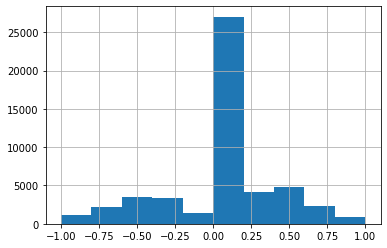

In [ ]:
translated_para["vader_prediction"].hist()

In [ ]:
translated_para[translated_para["vader_prediction"] > 0.6].sample(5)

,para_index,translated_sent_withEmoji,msg_date,msg_id,vader_prediction
15229,15235,"You weren't in the RBA or France, but you're t...",2020-11-02,91535,0.7998
17583,17590,- Any international awards or government awards?,2020-10-06,84472,0.7184
45935,45947,"Anyway, it's best to choose places that are po...",2020-08-12,29457,0.6369
29910,29919,"We got help from the guys at t.me/premenby, fo...",2020-09-15,73516,0.6696
37814,37824,"We're not here to argue about State symbols, b...",2020-08-23,60131,0.8597


In [ ]:
translated_para["translated_sent_withEmoji"][45935]

"Anyway, it's best to choose places that are poorly explored by the silhouettes."

In [ ]:
translated_msg = translated_df.groupby(["msg_index"]).agg({"translated_sent_withEmoji": " ".join}).reset_index()

In [ ]:
translated_msg

,msg_index,translated_sent_withEmoji
0,0,I agree.
1,1,I often go to meetings in Minsk!👍👍👍 No offense...
2,2,"And after that, how does the force structure f..."
3,3,He was in Minsk on Sunday. What's striking is ...
4,4,"Guys, I don't understand your arguments and di..."
...,...,...
38685,42923,"Belarus, there is no such country."
38686,42924,"If we take them or they take us, we'll show th..."
38687,42925,Homedad's with you.✌
38688,42926,"Congratulations, but for such ""smart"" people, ..."


In [ ]:
cols = ["msg_index", "msg_date", "msg_id"]
translated_msg = translated_msg.merge(ru[cols], how = "left", on = "msg_index")

In [ ]:
translated_msg = translated_msg.drop_duplicates(["msg_id"])

In [ ]:
translated_msg["vader_prediction"] = translated_msg["translated_sent_withEmoji"].apply(predict_sentiment)

<ipython-input-270-91171d7a0b13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  translated_msg["vader_prediction"] = translated_msg["translated_sent_withEmoji"].apply(predict_sentiment)


In [ ]:
#translated_msg

In [ ]:
translated_para["vader_sent"] = translated_para["translated_sent_withEmoji"].apply(predict_sentiment)

In [ ]:
sen_para = translated_para.groupby(["msg_date", "vader_sent"])["vader_sent"].count().unstack(level=-1).reset_index()

In [ ]:
cols = ["negative",	"neutral","positive"]
sen_para ["neg_perc"] = sen_para["negative"]/sen_para[cols].sum(axis=1)
sen_para ["pos_perc"] = sen_para["positive"]/sen_para[cols].sum(axis=1)

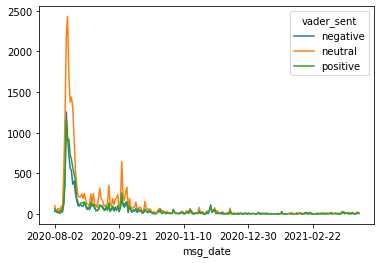

In [ ]:
sen_para.plot(x="msg_date", y=cols)

In [ ]:
translated_para

,para_index,translated_sent_withEmoji,msg_date,msg_id,vader_prediction,vader_sent
0,0,I agree.,2020-08-22,59694,0.3612,positive
1,1,I often go to meetings in Minsk!👍👍👍 No offense...,2020-08-22,59693,-0.3382,negative
2,2,"And after that, how does the force structure f...",2020-08-22,59692,-0.6981,negative
3,3,He was in Minsk on Sunday. What's striking is ...,2020-08-22,59691,0.9410,positive
4,4,"Guys, I don't understand your arguments and di...",2020-08-22,59687,-0.2124,negative
...,...,...,...,...,...,...
50690,50703,"Belarus, there is no such country.",2020-08-11,17109,-0.2960,negative
50691,50704,"If we take them or they take us, we'll show th...",2020-08-11,17108,0.0000,neutral
50692,50705,Homedad's with you.✌,2020-08-11,17103,0.0000,neutral
50693,50706,"Congratulations, but for such ""smart"" people, ...",2020-08-11,17090,-0.0516,negative


In [ ]:
p = translated_para["translated_sent_withEmoji"].str.contains("protest").value_counts()